# &#x1F9ED; Introducción a la predicción de series temporales (Time Series Forecasting)

Una serie temporal (time series) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de forecasting consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas.

Esta notebook describe cómo utilizar modelos de regresión de Scikit-learn para realizar forecasting de series temporales. En concreto, se hace uso de Skforecast, una librería que contiene las clases y funciones necesarias para adaptar cualquier modelo de regresión de Scikit-learn a problemas de forecasting.

# &#x1F4C8; Modelos de forecasting   

La principal adaptación que se necesita hacer para aplicar modelos de machine learning a problemas de forecasting es transformar la serie temporal en un matriz en la que, cada valor, está asociado a la ventana temporal (lags) que le precede.   


<div style="text-align:center;">
<img src="./img/transform_timeseries.gif">
<p>Transformación de una serie temporal en una matriz de 5 lags y un vector con el valor de la serie que sigue a cada fila de la matriz</p>
</div> 

Este tipo de transformación también puede incluir variables exógenas a la serie temporal.   

<div style="text-align:center;">
<img src="./img/matrix_transformation_with_exog_variable.png">
<p>Transformación de una serie temporal con variable exógena</p>
</div> 


Una vez que los datos se encuentran reordenados de esta forma, se puede entrenar cualquier modelo de regresión para que aprenda a predecir el siguiente valor de la serie.

## Predicciones multi-step   

Cuando se trabaja con series temporales, raramente se quiere predecir solo el siguiente elemento de la serie $(t_{+1})$, sino todo un intervalo futuro o un punto alejado en el tiempo $(t_{+n})$. A cada paso de predicción se le conoce como step. Existen varias estrategias que permiten generar este tipo de predicciones múltiples.   

## Recursive multi-step forecasting   

Dado que, para predecir el momento $t_n$ se necesita el valor de 
$t_{n−1}$, y $t_{n−1}$ se desconoce, se sigue un proceso recursivo en el que, cada nueva predicción, hace uso de la predicción anterior. A este proceso se le conoce como recursive forecasting o recursive multi-step forecasting y pueden generarse fácilmente con la clase ```ForecasterRecursive``` de la librería **skforecast**.   
<div style="text-align:center;">
<img src="./img/diagrama-multistep-recursiva.png" width="800">
<p>Predicción multi-step recursivo</p>
</div>     
     
<div style="text-align:center;">
<img src="./img/recursive_forecasting_gif.gif" width="800">
<p>Gráfica multi-step recursivo</p>
</div>
     


## Direct multi-step forecasting   

El método **direct multi-step forecasting** consiste en entrenar un modelo distinto para cada step. Por ejemplo, si se quieren predecir los siguientes 5 valores de una serie temporal, se entrenan 5 modelos distintos, uno para cada step. Como resultado, las predicciones son independientes unas de otras.   


<div style="text-align:center;">
<img src="./img/diagrama-prediccion-multistep-directa.png" width="800">
<p>Predicción multi-step directo</p>
</div>     
     
<div style="text-align:center;">
<img src="./img/direct_forecasting_gif.gif" width="800">
<p>Gráfica multi-step directo</p>
</div>

La principal complejidad de esta aproximación consiste en generar correctamente las matrices de entrenamiento para cada modelo. Todo este proceso está automatizado en la clase ```ForecasterDirect``` de la librería skforecast. También es importante tener en cuenta que esta estrategia tiene un coste computacional más elevado ya que requiere entrenar múltiples modelos. En el siguiente esquema se muestra el proceso para un caso en el que se dispone de la variable respuesta y dos variables exógenas.   

<div style="text-align:center;">
<img src="./img/diagram_skforecast_multioutput.png" width="800">
<p>Transformación de una serie temporal en en las matrices necesarias para entrenar un modelo direct multi-step forecasting</p>
</div>

## Forecasting multi-output   

Determinados modelos, por ejemplo, las redes neuronales LSTM, son capaces de predecir de forma simultánea varios valores de una secuencia (one-shot). Esta estrategia está disponible con la clase ```ForecasterRnn``` de la librería skforecast.

## &#x1F4C0; Librerías   

Las librerias a usar en este notebook son las siguientes:

In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme

# Modelado y Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster, load_forecaster
from skforecast.metrics import calculate_coverage
from skforecast.plot import plot_prediction_intervals
import shap

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")


Versión skforecast: 0.19.0
Versión scikit-learn: 1.7.2
Versión pandas: 2.3.3
Versión numpy: 2.2.6


## &#x1F4C2; Datos
Se dispone de una serie temporal con el gasto mensual (millones de dólares) en fármacos con corticoides que tuvo el sistema de salud Australiano entre 1991 y 2008. Se pretende crear un modelo autoregresivo capaz de predecir el futuro gasto mensual. Los datos empleados en los ejemplos de este notebook se han obtenido de la web [Forecasting: Principles and Practice](https://otexts.com/fpp3/) by Rob J Hyndman and George Athanasopoulos.

In [3]:
# Descarga de datos
# ==============================================================================
datos = fetch_dataset(name='h2o_exog', raw=True)

╭─────────────────────────────────── h2o_exog ────────────────────────────────────╮
│ Description:                                                                    │
│ Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health   │
│ system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are │
│ simulated.                                                                      │
│                                                                                 │
│ Source:                                                                         │
│ Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd      │
│ Edition). http://pkg.robjhyndman.com/fpp3package/,                              │
│ https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.             │
│                                                                                 │
│ URL:                                                                            │
│ https://raw.githubusercontent.com/skforecast/skforecast-                        │
│ datasets/main/data/h2o_exog.csv                                                 │
│                                                                                 │
│ Shape: 195 rows x 4 columns                                                     │
╰─────────────────────────────────────────────────────────────────────────────────╯

La columna *fecha* se ha almacenado como ```string```. Para convertirla en ```datetime```, se emplea la función ```pd.to_datetime()```. Una vez en formato ```datetime```, y para hacer uso de las funcionalidades de Pandas, se establece como *índice*. Además, dado que los datos son mensuales, se indica la frecuencia *(Monthly Started 'MS')*.

In [4]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()


,y,exog_1,exog_2
fecha,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


Cuando se utiliza el método asfreq() en Pandas, cualquier hueco en la serie temporal se rellena con valores NaN para ajustarse a la frecuencia especificada. Por lo tanto, es importante comprobar cualquier valor NaN añadido tras esta transformación.

In [5]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')


Número de filas con missing values: 0.0


Aunque no es necesario al haber establecido un frecuencia, se puede verificar que la serie temporal esté completa.

In [6]:
# Verificar que un índice temporal está completo
# ==============================================================================
fecha_inicio = datos.index.min()
fecha_fin = datos.index.max()
date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=datos.index.freq)
print(f"Índice completo: {(datos.index == date_range_completo).all()}")


Índice completo: True


In [7]:
# Completar huecos en un índice temporal
# ==============================================================================
# datos.asfreq(freq='30min', fill_value=np.nan)


Se utilizan los últimos 36 meses como conjunto de test para evaluar la capacidad predictiva del modelo.

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


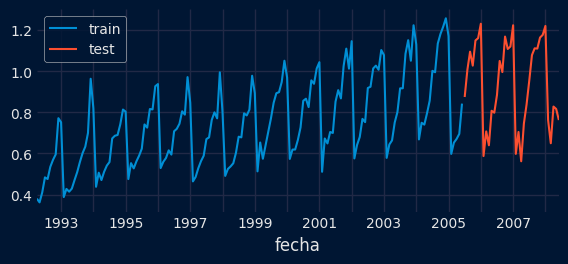

In [8]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

set_dark_theme()
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();


## Forecasting autorregresivo recursivo   

Se crea y entrena un modelo ```ForecasterRecursive``` a partir de un regresor ```RandomForestRegressor``` y una ventana temporal de 6 lags. Esto último significa que, el modelo, utiliza como predictores los 6 meses anteriores.

In [9]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                estimator = RandomForestRegressor(random_state=123),
                lags = 6
             )
forecaster.fit(y=datos_train['y'])
forecaster


=================== 
ForecasterRecursive 
=================== 
Estimator: RandomForestRegressor 
Lags: [1 2 3 4 5 6] 
Window features: None 
Window size: 6 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <MonthBegin> 
Estimator parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-12-01 09:51:33 
Last fit date: 2025-12-01 09:51:33 
Skforecast version: 0.19.0 
Python version: 3.12.3 
Forecaster id: None

## Predicciones    

Una vez entrenado el modelo, se predicen los datos de test (36 meses a futuro).

In [10]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)


2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

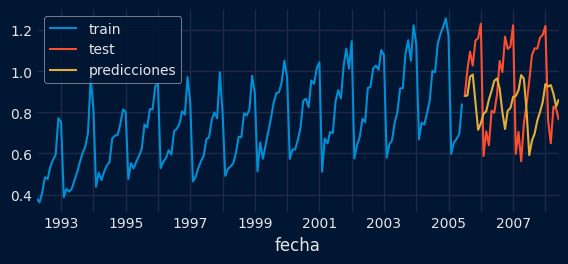

In [11]:
# Gráfico de predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();


## Error de predicción en los datos de test   

Se cuantifica el error que comete el modelo en sus predicciones. En este caso, se emplea como métrica el mean squared error (mse).



In [12]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")


Error de test (mse): 0.07326833976120374


## Ajuste de hiperparámetros (tuning)    

El ```ForecasterRecursive``` entrenado ha utilizado una ventana temporal de 6 lags y un modelo Random Forest con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. La librería Skforecast proporciona varias estrategias de búsqueda para encontrar la mejor combinación de hiperparámetros y lags. En este caso, se utiliza la función ```grid_search_forecaster```, que compara los resultados obtenidos con cada combinación de hiperparámetros y lags, e identifica la mejor.

In [13]:
# Búsqueda de hiperparámetros: grid search
# ==============================================================================
forecaster = ForecasterRecursive(
                estimator = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Particiones de entrenamiento y validación
cv = TimeSeriesFold(
      steps              = 36,
      initial_train_size = int(len(datos_train) * 0.5),
      refit              = False,
      fixed_train_size   = False,

    )

# Valores candidatos de lags
lags_grid = [10, 20]

# Valores candidatos de hiperparámetros del regresor
param_grid = {
      'n_estimators': [100, 250],
      'max_depth': [3, 5, 10]
}

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train['y'],
                        cv          = cv,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        metric      = 'mean_squared_error',  
                        return_best = True,
                        n_jobs      = 'auto',
                        verbose     = False
                  )


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 0.02177319540541341


In [14]:
# Resultados de la búsqueda de hiperparámetros
# ==============================================================================
resultados_grid


,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 250}",0.021773,3,250
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 250}",0.021852,5,250
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 250}",0.021909,10,250
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.022530,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.022569,3,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.023400,10,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.063144,3,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 250}",0.064241,3,250
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.066307,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.067151,5,100


Los mejores resultados se obtienen si se utiliza una ventana temporal de 20 lags y una configuración de Random Forest ```{'max_depth': 3, 'n_estimators': 250}```.

## Modelo final    

Finalmente, se entrena de nuevo un ```ForecasterRecursive``` con la mejor configuración encontrada. Este paso no es necesario si se indica ```return_best = True``` en la función  ```grid_search_forecaster```.

In [15]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
estimator = RandomForestRegressor(n_estimators=250, max_depth=3, random_state=123)
forecaster = ForecasterRecursive(
                estimator = estimator,
                lags      = 20
             )
forecaster.fit(y=datos_train['y'])


In [16]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)


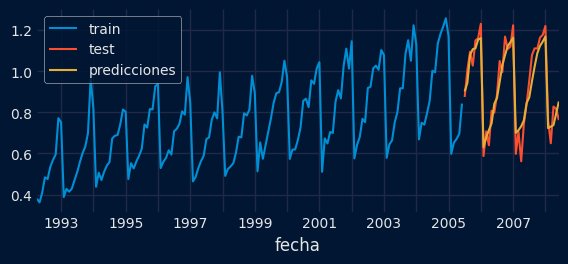

In [17]:
# Gráfico de predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();


In [18]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")


Error de test (mse) 0.004356831371529945


Como se puede observar, aplicando la combinación óptima de hiperparámetros se consigue reducir notablemente el error de test.

# &#x1F550; Backtesting    

Para obtener una estimación robusta de la capacidad predictiva del modelo, se lleva a cabo un proceso de **backtesting**. El **backtesting** consiste en evaluar el comportamiento de un modelo predictivo al aplicarlo de forma retrospectiva sobre datos históricos. Por lo tanto, es una estrategia de validación que permite cuantificar la capacidad predictiva de un modelo.

### Backtesting con reentrenamiento   

El modelo se entrena cada vez antes de realizar las predicciones, de esta forma, se incorpora toda la información disponible hasta el momento. Se trata de una adaptación del proceso de cross-validation en el que, en lugar de hacer un reparto aleatorio de las observaciones, el conjunto de entrenamiento se incrementa de manera secuencial, manteniendo el orden temporal de los datos.   

<div style="text-align:center;">
<img src="./img/backtesting_refit.gif" width="800">
<p>Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps y reentrenamiento en cada iteración.</p>
</div>   


### Backtesting con reentrenamiento y tamaño de entrenamiento constante   

Similar a la estrategia anterior, pero, en este caso, el tamaño del conjunto de entrenamiento no se incrementa sino que la ventana de tiempo que abarca se desplaza. Esta estrategia se conoce también como time series cross-validation o walk-forward validation.


<div style="text-align:center;">
<img src="./img/backtesting_refit_fixed_train_size.gif" width="800">
<p>Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps y reentrenamiento en cada iteración.</p>
</div>   


### Backtesting con reentrenamiento cada n periodos (intermitente)

El modelo se reentrena de forma intermitente cada $n$ periodos de predicción.     
Esta estrategia suele lograr un buen equilibrio entre el coste computacional del reentrenamiento y evitar la degradación del modelo.    

<div style="text-align:center;">
<img src="./img/backtesting_intermittent_refit.gif" width="800">
<p>Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps y una frecuencia de reentrenamiento intermitenteación.</p>
</div>   

### Backtesting sin reentrenamiento

Con esta estrategia, el modelo se entrena una única vez con un conjunto inicial y se realizan las predicciones de forma secuencial sin actualizar el modelo y siguiendo el orden temporal de los datos. Esta estrategia tiene la ventaja de ser mucho más rápida puesto que el modelo solo se entrena una vez. La desventaja es que el modelo no incorpora la última información disponible por lo que puede perder capacidad predictiva con el tiempo.

<div style="text-align:center;">
<img src="./img/backtesting_no_refit.gif" width="800">
<p>Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps y sin reentrenamiento en cada iteracción.</p>
</div>   


### Backtesting con fold stride

Este método implica controlar qué tan lejos se mueve el conjunto de test entre los folds. Por ejemplo, es posible que desee predecir los próximos 30 días pero generar una nueva predicción cada 7 días. En esta configuración, cada ventana de test tiene una duración de 30 días (```steps=30```), mientras que el avance entre folds es de una semana (```fold_stride=7```). Esto significa que los pronósticos se superponen y las mismas observaciones se predicen varias veces, lo que proporciona una visión más rica de la consistencia y estabilidad del modelo en diferentes orígenes de pronóstico.

Dependiendo de la relación entre ```steps``` y ```fold_stride```, la salida puede incluir índices repetidos (si ```fold_stride``` < ```steps```) o huecos (si ```fold_stride``` > ```steps```).

#### Skip folds

Todos las estrategias de backtesting mencionadas pueden combinarse con la opción de saltarse un cierto número de folds mediante el argumento ```skip_folds```. Dado que el modelo predice menos puntos en el tiempo, el coste computacional se reduce y el proceso de backtesting es más rápido. Esto es particularmente útil cuando se busca una estimación aproximada del rendimiento del modelo, pero no se requiere una evaluación exacta, por ejemplo, al buscar hiperparámetros. Si ```skip_folds``` es un entero, se devolverá cada **'skip_folds'-ésimo**. Si ```skip_folds``` es una lista, se saltarán los folds de la lista. Por ejemplo, si ```skip_folds = 3```, y hay 10 folds, los folds devueltos serán [0, 3, 6, 9]. Si ```skip_folds``` es una lista [1, 2, 3], los folds devueltos serán [0, 4, 5, 6, 7, 8, 9].


La librería **skforecast** dispone de múltiples estrategias de backtesting mencionadas. Independientemente de cuál se utilice, es importante no incluir los datos de test en el proceso de búsqueda para no caer en problemas de overfitting.

Para este ejemplo, se sigue una estrategia de backtesting con reentrenamiento. Internamente, el proceso seguido por la función es el siguiente:

- En la primera iteración, el modelo se entrena con las observaciones seleccionadas para el entrenamiento inicial (en este caso, 87). Después, se predicen las siguientes 36 observaciones.

- En la segunda iteración, se reentrena el modelo extendiendo el conjunto de entrenamiento inicial con 36 observaciones (87 + 36), y se predicen las siguientes 36.

- Este proceso se repite hasta que se utilizan todas las observaciones disponibles y se calcula la métrica de validación con todas las predicciones acumuladas. Siguiendo esta estrategia, el conjunto de entrenamiento aumenta en cada iteración con tantas observaciones como steps se estén prediciendo.

La clase ```TimeSeriesFold``` permite crear las particiones necesarias en el proceso de backtesting. Ofrece una gran flexibilidad, permitiendo simular diferentes escenarios como *refit*, *no refit*, *rolling origin* y otros. El método ```split``` devuelve las posiciones de las series temporales correspondientes a cada partición. Si se especifica ```as_pandas=True```, el resultado es un DataFrame con información detallada, incluyendo nombres descriptivos en las columnas.


In [19]:
# Particiones de backtesting utilizando TimeSeriesFold
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 12 * 3, 
         initial_train_size = len(datos['y']) - 12 * 9,  # Los últimos 9 años utilizados para el backtest
         window_size        = 20,
         fixed_train_size   = False,
         refit              = True,
)

cv.split(X=datos['y'], as_pandas=True)


Information of folds
--------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



,fold,train_start,train_end,last_window_start,last_window_end,test_start,test_end,test_start_with_gap,test_end_with_gap,fit_forecaster
0,0,0,87,67,87,87,123,87,123,True
1,1,0,123,103,123,123,159,123,159,True
2,2,0,159,139,159,159,195,159,195,True


Cuando se utiliza en combinación con ```backtesting_forecaster```, no es necesario especificar el argumento ```window_size``` ya que ```backtesting_forecaster``` establece automáticamente basándose en la configuración del forecaster. Esto garantiza que el proceso de backtesting se ajuste perfectamente a los requisitos del forecaster.

In [22]:
# Backtesting
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 12 * 3, 
         initial_train_size = len(datos) - 12 * 9,
         fixed_train_size   = False,
         refit              = True,
     )

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = datos['y'],
                                    cv         = cv,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                                 )
metrica


Information of folds
--------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

,mean_squared_error
0,0.010233


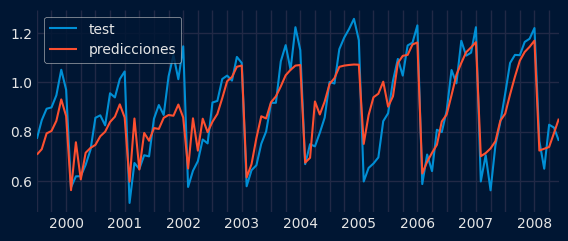

In [21]:
# Gráfico de predicciones de backtest vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos.loc[predicciones_backtest.index, 'y'].plot(ax=ax, label='test')
predicciones_backtest['pred'].plot(ax=ax, label='predicciones')
ax.legend();


## Explicabilidad del modelo   

Debido a la naturaleza compleja de muchos de los actuales modelos de machine learning, a menudo funcionan como cajas negras, lo que dificulta entender por qué han hecho una predicción u otra. Las técnicas de explicabilidad pretenden desmitificar estos modelos, proporcionando información sobre su funcionamiento interno y ayudando a generar confianza, mejorar la transparencia y cumplir los requisitos normativos en diversos ámbitos. Mejorar la explicabilidad de los modelos no sólo ayuda a comprender su comportamiento, sino también a identificar sesgos, mejorar su rendimiento y permitir a las partes interesadas tomar decisiones más informadas basadas en los conocimientos del machine learning.

Skforecast es compatible con algunos de los métodos de explicabilidad más populares: model-specific feature importances, SHAP values, and partial dependence plots.    

#### **Importancia model-specific**

In [23]:
# Importancia predictores
# ==============================================================================
importancia = forecaster.get_feature_importances()
importancia.head(10)


,feature,importance
11,lag_12,0.815564
1,lag_2,0.086286
13,lag_14,0.019047
9,lag_10,0.013819
2,lag_3,0.012943
14,lag_15,0.009637
0,lag_1,0.009141
10,lag_11,0.008130
7,lag_8,0.007377
8,lag_9,0.005268


&#x1F4CC; NOTA    
  
```get_feature_importances()``` solo devuelve valores si el regresor utilizado dentro del forecaster tiene el atributo ```coef_``` o ```feature_importances_```.

#### **Shap values**   


Los valores SHAP (SHapley Additive exPlanations) son un método muy utilizado para explicar los modelos de machine learning, ya que ayudan a comprender cómo influyen las variables y los valores en las predicciones de forma visual y cuantitativa.

Se puede obtener un análisis SHAP a partir de modelos skforecast con sólo dos elementos:

- El **regresor interno** del forecaster.

- Las **matrices de entrenamiento** creadas a partir de la serie temporal y variables exógenas, utilizadas para ajustar el pronosticador.

Aprovechando estos dos componentes, los usuarios pueden crear explicaciones interpretables para sus modelos de skforecast. Estas explicaciones pueden utilizarse para verificar la fiabilidad del modelo, identificar los factores más significativos que contribuyen a las predicciones y comprender mejor la relación subyacente entre las variables de entrada y la variable objetivo.

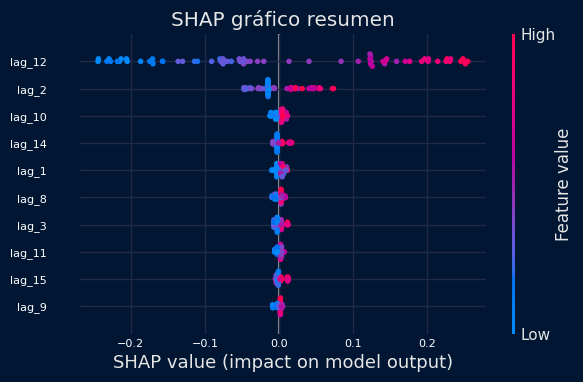

In [25]:
# Matrices de entrenamiento utilizadas por el forecaster para entrenar el regresor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(y=datos_train['y'])

# Crear SHAP explainer (para modelos basados en árboles)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.estimator)
# Se selecciona una muestra del 50% de los datos para acelerar el cálculo
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train) * 0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

# Shap summary plot (top 10)
# ==============================================================================
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP gráfico resumen")
ax.tick_params(labelsize=8, colors='white')
fig.set_size_inches(6, 3.5)


&#x1F4CC; NOTA     
 
La librería Shap cuenta con varios *Explainers*, cada uno diseñado para un tipo de modelo diferente. El ```shap.TreeExplainer``` se utiliza para modelos basados en árboles, como el ```RandomForestRegressor``` utilizado en este ejemplo. Para más información, consultar la [documentación de SHAP](https://shap.readthedocs.io/en/latest/index.html).

#### **Explicabilidad de una predicción concreta**

Los valores SHAP no solo permiten interpretar el comportamiento general del modelo, sino que también son una herramienta poderosa para analizar predicciones individuales. Esto resulta especialmente útil cuando se quiere entender cómo se ha generado una predicción específica y qué variables han contribuido a ella.

Para llevar a cabo este análisis, es necesario acceder a los valores de los predictores —en este caso, los lags— en el momento de la predicción. Esto puede lograrse utilizando el método ```create_predict_X``` o bien activando el argumento ```return_predictors=True``` en la función ```backtesting_forecaster```.

Vayamos a suponer que se quiere entender la predicción obtenida durante el backtesting para la fecha ***2005-04-01***.

In [26]:
# Backtesting indicando que se devuelvan los predictores
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 12 * 3, 
         initial_train_size = len(datos) - 12 * 9,
         fixed_train_size   = False,
         refit              = True,
     )

_, predicciones_backtest = backtesting_forecaster(
                                    forecaster        = forecaster,
                                    y                 = datos['y'],
                                    cv                = cv,
                                    return_predictors = True,
                                    metric            = 'mean_squared_error',
                                 )


  0%|          | 0/3 [00:00<?, ?it/s]

Al indicar ```return_predictors=True```, se obtiene un DataFrame con el valor predicho (```'pred'```), la partición en la que se encuentra (```'fold'```) y el valor de los lags utilizados para realizar cada predicción.

In [27]:
predicciones_backtest.head()


,fold,pred,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
1999-07-01,0,0.706470,0.703872,0.639238,0.573976,0.652996,0.512696,0.893081,0.977732,0.813009,...,0.678075,0.681245,0.603366,0.552091,0.536649,0.524408,0.490557,0.800544,0.994389,0.770522
1999-08-01,0,0.728661,0.706470,0.703872,0.639238,0.573976,0.652996,0.512696,0.893081,0.977732,...,0.794893,0.678075,0.681245,0.603366,0.552091,0.536649,0.524408,0.490557,0.800544,0.994389
1999-09-01,0,0.792769,0.728661,0.706470,0.703872,0.639238,0.573976,0.652996,0.512696,0.893081,...,0.784624,0.794893,0.678075,0.681245,0.603366,0.552091,0.536649,0.524408,0.490557,0.800544
1999-10-01,0,0.802519,0.792769,0.728661,0.706470,0.703872,0.639238,0.573976,0.652996,0.512696,...,0.813009,0.784624,0.794893,0.678075,0.681245,0.603366,0.552091,0.536649,0.524408,0.490557
1999-11-01,0,0.843620,0.802519,0.792769,0.728661,0.706470,0.703872,0.639238,0.573976,0.652996,...,0.977732,0.813009,0.784624,0.794893,0.678075,0.681245,0.603366,0.552091,0.536649,0.524408


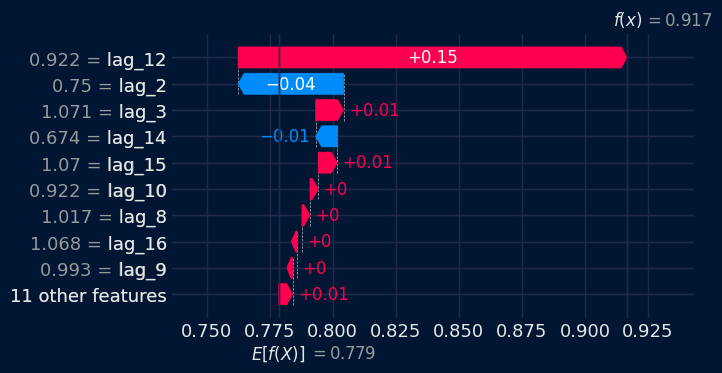

In [28]:
# Waterfall para una predicción concreta
# ==============================================================================
iloc_predicted_date = predicciones_backtest.index.get_loc('2005-04-01')
shap_values_single = explainer(predicciones_backtest.iloc[:, 2:])
shap.plots.waterfall(shap_values_single[iloc_predicted_date], show=False)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(6, 3.5)
plt.show();


Para esta fecha en concreto, los predictores más influyentes han sido el 12 y el 2, el primero de ellos contribuyendo de forma positiva y el segundo de forma negativa.

## Forecasting con variables exógenas.   

En el ejemplo anterior, se han utilizado como predictores únicamente lags de la propia variable predicha. En ciertos escenarios, es posible disponer de información sobre otras variables, ***cuyo valor a futuro se conoce***, y pueden servir como predictoreres adicionales en el modelo.

Siguiendo con el ejemplo anterior, se simula una nueva variable cuyo comportamiento está correlacionado con la serie temporal modelada y que, por lo tanto, se quiere incorporar como predictor. Esto mísmo es aplicable a múltiples variables exógenas.

In [29]:
# Descarga de datos
# ==============================================================================
datos = fetch_dataset(name='h2o_exog', raw=True, verbose=False)


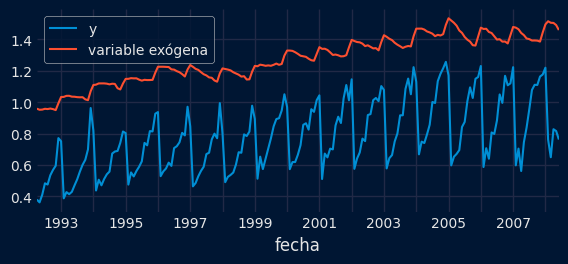

In [30]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

fig, ax = plt.subplots(figsize=(6, 2.5))
datos['y'].plot(ax=ax, label='y')
datos['exog_1'].plot(ax=ax, label='variable exógena')
ax.legend(loc='upper left')
plt.show();


In [31]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(
    f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})"
)
print(
    f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})"
)


Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [32]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                estimator = RandomForestRegressor(random_state=123),
                lags      = 8
             )
forecaster.fit(y=datos_train['y'], exog=datos_train['exog_1'])


Si el ```ForecasterRecursive``` se entrena con una variable exógena, hay que pasarle el valor de esta variable al ```predict()```. Por lo tanto, solo es aplicable a escenarios en los que se dispone de información a futuro de la variable exógena.

In [33]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])


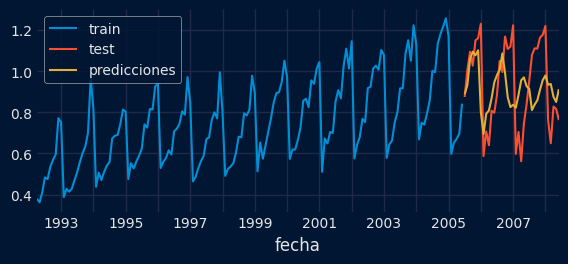

In [34]:
# Gráfico predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()
plt.show();


In [35]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")


Error de test (mse): 0.03989087922533575


## Predictores custom y window features   

En determinados escenarios, puede ser interesante incorporar otras características de la serie temporal además de los lags, por ejemplo, la media movil de los últimos n valores puede servir para capturar la tendencia de la serie. El argumento ```window_features``` permite incorporar al modelo predictores adicionales, creados a partir de los valores pasados de la serie temporal.

La clase ```RollingFeatures``` disponible en skforecast permite crear algunos de los predictores más utilizados:

- **'mean'**: la media de los n valores anteriores.

- **'std'**: la desviación estándar de los n valores anteriores.

- **'min'**: el mínimo de los n valores anteriores.

- **'max'**: el máximo de los n valores anteriores.

- **'sum'**: la suma de los n valores anteriores.

- **'median'**: la mediana de los n valores anteriores.

- **'ratio_min_max'**: la relación entre el mínimo y el máximo de los n valores anteriores.

- **'coef_variation'**: el coeficiente de variación de los n valores anteriores.   


El usuario puede especificar un tamaño de ventana diferente para cada uno de ellos o el mismo para todos.

&#x1F4CC; NOTA    

```RollingFeatures``` es muy útil para incluir algunos de los predictores más utilizados. Sin embargo, es posible que se necesite incluir otros predictores que no estén disponibles en esta clase. En este caso, el usuario puede crear su propia clase para calcular los predictores deseadas e incluirlos en el forecaster. Para más información, consultar la [documentación de window-features and custom features](https://skforecast.org/0.19.0/user_guides/window-features-and-custom-features.html).

In [36]:
# Descarga de datos
# ==============================================================================
datos = fetch_dataset(name='h2o_exog', raw=True, verbose=False)

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")


Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


Se crea y entrena un de nuevo un ```ForecasterRecursive``` a partir de un regresor ```RandomForestRegressor``` pero esta vez, además de los 10 lags, se incluyen como predictores la media móvil, valor máximo, valor mínimo y desviación típica de los últimos 20 valores.

In [37]:
# Window features
# ==============================================================================
window_features = RollingFeatures(
    stats = ['mean', 'std', 'min', 'max'],
    window_sizes = 20
)


In [38]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                estimator       = RandomForestRegressor(random_state=123),
                lags            = 10,
                window_features = window_features,
             )
forecaster.fit(y=datos_train['y'])
forecaster


=================== 
ForecasterRecursive 
=================== 
Estimator: RandomForestRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window features: ['roll_mean_20', 'roll_std_20', 'roll_min_20', 'roll_max_20'] 
Window size: 20 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <MonthBegin> 
Estimator parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-12-01 11:52:57 
Last fit date: 2025-12-01 11:52:57 
Skforecast version: 0.19.0 
Python version: 3.12.3 
Forecaster id: None

Mediante el método ```create_train_X_y```, se puede acceder a las matrices que se crean internamente en el proceso de entrenamiento del forecaster y que se utilizan para ajustar el modelo. Esto permite al usuario inspeccionar los datos y entender cómo se han creado los predictores.

In [39]:
# Matrices de entrenamiento
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(y=datos_train['y'])
display(X_train.head(5))
display(y_train.head(5))


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,roll_mean_20,roll_std_20,roll_min_20,roll_max_20
fecha,,,,,,,,,,,,,,
1993-12-01,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.387554,0.523089,0.122733,0.361801,0.771258
1994-01-01,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.552253,0.152567,0.361801,0.963081
1994-02-01,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.575129,0.156751,0.387554,0.963081
1994-03-01,0.437670,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.576486,0.155363,0.387554,0.963081
1994-04-01,0.506121,0.437670,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.577622,0.154728,0.387554,0.963081


fecha
1993-12-01    0.963081
1994-01-01    0.819325
1994-02-01    0.437670
1994-03-01    0.506121
1994-04-01    0.470491
Freq: MS, Name: y, dtype: float64

In [40]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)


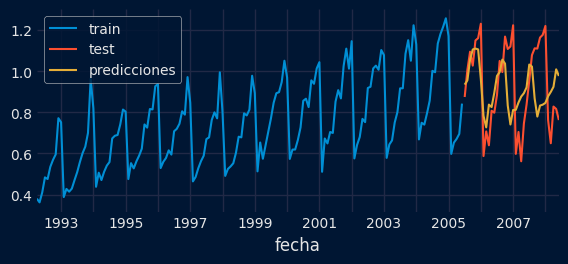

In [41]:
# Gráfico predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()
plt.show();


In [42]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")


Error de test (mse): 0.04180143590431811


## Direct multi-step forecasting   

Para conseguir predicciones de varios steps a futuro, los modelos ```ForecasterRecursive``` siguen una estrategia de predicción recursiva en la que, cada nueva predicción, se basa en la predicción anterior. Una alternativa es entrenar un modelo para cada uno de los steps que se desea predecir. Esta estrategia, normalmente conocida como direct multi-step forecasting, es computacionalmente más costosa que la recursiva puesto que requiere entrenar varios modelos. Sin embargo, en algunos escenarios, consigue mejores resultados. Este tipo de modelos pueden obtenerse con la clase ```ForecasterDirect``` y pueden incluir también window features y variables exógenas.

&#x1F4CC; NOTA   

Los ```ForecasterDirect``` pueden requerir tiempos de entrenamiento elevados, ya que se ajusta un modelo por cada step.   

A diferencia de cuando se utiliza ```ForecasterRecursive```, en los modelos de tipo ```ForecasterDirect``` hay que indicar, en el momento de su creación, el número de **steps** que se quieren predecir. No es posible predecir **steps** más allá del valor definido en su creación.

Para este ejemplo, se utiliza como regresor un modelo lineal con penalización de *Ridge*. Estos modelos requieren que los predictores se estandaricen, por lo que se combina con un ```StandardScaler```. Para una documentación más detallada de como incluir transformers y pipelines, visitar: [skforecast with transformers and pipeline](https://skforecast.org/0.19.0/user_guides/sklearn-transformers-and-pipeline.html).

In [43]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterDirect(
                estimator     = Ridge(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8 # Este valor será remplazado en el grid search
             )


In [44]:
# Búsqueda de hiperparámetros
# ==============================================================================
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

cv = TimeSeriesFold(
         steps              = 36, 
         initial_train_size = int(len(datos_train) * 0.5),
         fixed_train_size   = False,
         refit              = False,
     )

param_grid = {'alpha': np.logspace(-5, 5, 10)}

lags_grid = [5, 12, 20]

resultados_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = datos_train['y'],
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',
                    return_best = True
                )


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': np.float64(0.2782559402207126)}
  Backtesting metric: 0.027413948265204567


In [45]:
# Resultados de la búsqueda de hiperparámetros
# ==============================================================================
resultados_grid.head()


,lags,lags_label,params,mean_squared_error,alpha
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.2782559402207126},0.027414,0.278256
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 3.593813663804626},0.027435,3.593814
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.021544346900318846},0.027484,0.021544
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0016681005372000592},0.027490,0.001668
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0001291549665014884},0.027491,0.000129


Los mejores resultados se obtienen utilizando una ventana temporal de 12 lags y una configuración de Lasso ```{'alpha': 0.2782559}```.

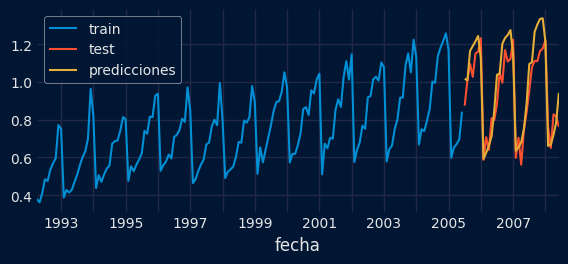

In [46]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict()

# Gráfico predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()
plt.show();


In [47]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")


Error de test (mse) 0.011792965469623133


## Forecasting probabilístico   

El forecasting probabilístico es una familia de técnicas que permite predecir la distribución esperada del de la serie en lugar de un único valor. Este tipo de pronóstico proporciona mucha más información, ya que permite la creación de intervalos de predicción.

Un intervalo de predicción define el espacio dentro del cual es de esperar que se encuentre el verdadero valor de 
y
 con una determinada probabilidad. Por ejemplo, es de esperar que el intervalo de predicción (1, 99) contenga el verdadero valor de la predicción con un 98% de probabilidad.   

 <div style="text-align:center;">
<img src="./img/bootstrapped-prediction-interval.gif" width="1200">
<p>Diagrama de creación de intervalos de predicción usando bootstrapping.</p>
</div>   


Skforecast implementa varios métodos para el pronóstico probabilístico:

- Forecasting probabilístico: Bootstrapping

- Forecasting probabilístico: Predicción conformal

- Forecasting probabilístico: Regresión cuantílica

In [48]:
# Descarga de datos
# ==============================================================================
datos = fetch_dataset(name='h2o_exog', raw=True, verbose=False)

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")


Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [49]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
               estimator = Ridge(alpha=0.1, random_state=765),
               lags = 15
             )
forecaster.fit(y=datos_train['y'], store_in_sample_residuals=True)

# Intervalos de predicción
# ==============================================================================
predicciones = forecaster.predict_interval(
                  steps    = steps,
                  interval = [5, 95],
                  method   = 'bootstrapping',
                  n_boot   = 150
               )
predicciones.head(5)


,pred,lower_bound,upper_bound
2005-07-01,0.970598,0.788690,1.059012
2005-08-01,0.990932,0.815214,1.102761
2005-09-01,1.149609,1.064396,1.258934
2005-10-01,1.194584,1.098682,1.313509
2005-11-01,1.231744,1.122570,1.355601


Error de test (mse): 0.010465086161791277


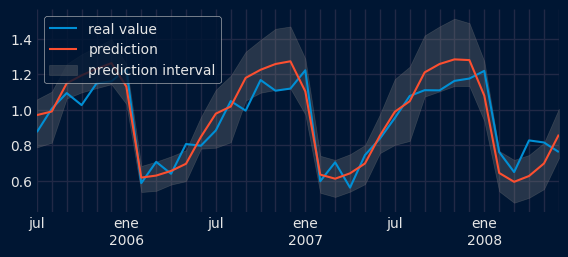

In [50]:
# Error de predicción
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones['pred']
            )
print(f"Error de test (mse): {error_mse}")

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
plot_prediction_intervals(
    predictions         = predicciones,
    y_true              = datos_test,
    target_variable     = "y",
    ax                  = ax,
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
)
plt.show();


Information of folds
--------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

,mean_squared_error
0,0.012641


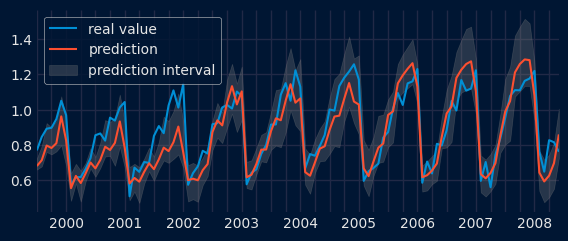

In [52]:
# Backtest con intervalos de predicción
# ==============================================================================
forecaster = ForecasterRecursive(
                estimator = Ridge(alpha=0.1, random_state=765),
                lags      = 15
             )
cv = TimeSeriesFold(
         steps              = 36, 
         initial_train_size = len(datos) - 12 * 9,
         fixed_train_size   = False,
         refit              = True,
)
metrica, predicciones = backtesting_forecaster(
                            forecaster      = forecaster,
                            y               = datos['y'],
                            cv              = cv,
                            metric          = 'mean_squared_error',
                            interval        = [5, 95],
                            interval_method = "bootstrapping",
                            n_boot          = 150,
                            verbose         = True
                       )
display(metrica)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
plot_prediction_intervals(
    predictions         = predicciones,
    y_true              = datos.loc[predicciones.index, :],
    target_variable     = "y",
    ax                  = ax,
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
)
plt.show();


In [53]:
# Cobertura del intervalo predicho
# ==============================================================================
cobertura = calculate_coverage(
                y_true      = datos.loc[predicciones.index, 'y'],
                lower_bound = predicciones['lower_bound'],
                upper_bound = predicciones['upper_bound'],
            )
print(f"Cobertura del intervalo predicho: {round(100 * cobertura, 2)} %")


Cobertura del intervalo predicho: 77.78 %


## Métrica custom   

En los procesos de backtesting (```backtesting_forecaster```) y optimización de hiperparámetros (```grid_search_forecaster```), además de las métricas ```mean_squared_error```, ```mean_absolute_error``` y ```mean_absolute_percentage_error```, el usuario puede utilizar cualquier función que desee siempre y cuando cumpla lo siguiente:

- Tiene como argumentos:

    - ```y_true```: verdaderos valores de la serie.

    - ```y_pred```: valores predichos.

- Devuelve un valor numérico (float o int).

- El modelo es mejor cuanto menor es la métrica. Esto únicamente es necesario si se quiere que la función ```grid_search_forecaster``` reentrene automáticamente el mejor modelo encontrado.   


Gracias a esta flexibilidad, es posible evaluar la capacidad predictiva del modelo con métricas aplicables a escenarios muy diversos. Por ejemplo:

- Considerar únicamente determinados meses, días u horas.

- Considerar únicamente fechas que sean festivos.

- Considerar únicamente el último step del horizonte predicho.   


Véase un ejemplo en el que se quiere predecir un horizonte de 12 meses, pero únicamente considerar los últimos 3 meses de cada año para calcular la métrica de interés.

In [54]:
# Métrica custom 
# ==============================================================================
def custom_metric(y_true, y_pred):
    '''
    Calcular el mean_absolute_error utilizando únicamente las predicciones de
    los últimos 3 meses del año.
    '''
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric


In [55]:
# Backtesting 
# ==============================================================================
metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = datos['y'],
                                    cv         = cv,
                                    metric     = custom_metric,
                                    verbose    = True
                                 )
metrica


Information of folds
--------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

,custom_metric
0,0.128159


# &#x1F4BE; Guardar y cargar modelos   

Los modelos generados con *Skforecast* se pueden cargar y guardar usando las librerías Pickle o Joblib. Para facilitar el proceso, dos funciones están disponibles: save_forecaster y load_forecaster. A continuación, se muestra un sencillo ejemplo. Para más información cosultar: skforecast save and load forecaster.

In [56]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterRecursive(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=datos['y'])
forecaster.predict(steps=3)


2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
Freq: MS, Name: pred, dtype: float64

In [57]:
# Guardar modelo
# ==============================================================================
save_forecaster(forecaster, file_name='forecaster.joblib', verbose=False)


In [58]:
# Cargar modelo
# ==============================================================================
forecaster_cargado = load_forecaster('forecaster.joblib')


ForecasterRecursive 
Estimator: RandomForestRegressor 
Lags: [1 2 3] 
Window features: None 
Window size: 3 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2008-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <MonthBegin> 
Estimator parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-12-01 12:18:44 
Last fit date: 2025-12-01 12:18:44 
Skforecast ve

In [59]:
# Predicciones
# ==============================================================================
forecaster_cargado.predict(steps=3)


2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
Freq: MS, Name: pred, dtype: float64

&#x1F4CC; NOTA    

Cuando se utilizan ```window_features``` o ```metric``` personalizadas, estas de deben definir antes de cargar el forecaster, de lo contrario, se producirá un error. Por lo tanto, se recomienda guardar la función en un archivo separado e importarla antes de cargar el forecaster.

# &#x1F680; Uso de modelos en producción   

En los proyectos relacionados con forecasting es frecuente que, como resultado de la etapa de experimentación y desarrollo, se genere un modelo. Para que este modelo consiga un impacto real en el negocio, se tiene que poder poner en producción y generar predicciones cada cierto tiempo, con las que tomar decisiones. Esta necesidad ha guiado en gran medida el desarrollo de la librería ***Skforecast***.

Supóngase un caso de uso en el que se han de generar predicciones de forma semanal, por ejemplo, cada lunes el modelo tiene que predecir el resto de la semana. Una forma de conseguir este comportamiento es reentrenando el modelo semanalmente justo antes de que se ejecute la primera predicción y llamar a continuación al método ```predict``` del objeto *forecaster*.

Esta estrategia, si bien es sencilla, puede no ser posible de utilizar en la práctica por varias razones:

- El entrenamiento del modelo es muy costoso y no puede ejecutarse con tanta frecuencia.

- Ya no se dispone del histórico con el que se entrenó el modelo.

- La frecuencia de predicción es tan elevada que no se dispone de tiempo para entrenar el modelo entre predicción y predicción.

En estos casos, es necesario que el modelo pueda ejecutarse en cualquier momento aunque no se haya entrenado recientemente.

Todos los modelos generados por la librería Skforecast disponen en su método ```predict``` del argumento ```last_window```. Gracias a él, se pueden proporcionar únicamente los valores pasados que necesita el modelo para crear los predictores autorregresivos (lags) y así generar las predicciones sin necesidad de reentrenar el modelo.

Para una documentación más detallada, visitar: [skforecast forecaster en producción](https://skforecast.org/0.19.0/user_guides/forecaster-in-production.html).



In [60]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                estimator = RandomForestRegressor(random_state=123),
                lags = 6
             )
forecaster.fit(y=datos_train['y'])


En este caso, dado que el modelo utiliza como predictores los últimos 6 lags, ```last_window``` debe de contener como mínimo los 6 valores previos al momento donde se quiere iniciar la predicción.

In [61]:
# Predecir con last_window
# ==============================================================================
last_window = datos_test['y'][-6:]
forecaster.predict(last_window=last_window, steps=4)


2008-07-01    0.757750
2008-08-01    0.836313
2008-09-01    0.877668
2008-10-01    0.911734
Freq: MS, Name: pred, dtype: float64

Si el forecaster utiliza variables exógenas, además de ```last_window```, se le deben proporcionar los valores futuros de las variables exógenas mediante el argumento ```exog``.


# &#x1F4BB; Información de sesión

In [63]:
import session_info
session_info.show(html=False)


-----
matplotlib          3.10.7
numpy               2.2.6
pandas              2.3.3
session_info        v1.0.1
shap                0.50.0
skforecast          0.19.0
sklearn             1.7.2
-----
IPython             9.7.0
jupyter_client      8.6.3
jupyter_core        5.9.1
-----
Python 3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]
Linux-6.14.0-36-generic-x86_64-with-glibc2.39
-----
Session information updated at 2025-12-01 12:27


# &#x1F4DA; Bibliografía   

- Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia.

- Time Series Analysis and Forecasting with ADAM Ivan Svetunkov

- Joseph, M. (2022). Modern time series forecasting with Python: Explore industry-ready time series forecasting using modern machine learning and Deep Learning. Packt Publishing.

- Python for Finance: Mastering Data-Driven Finance

## &#x1F4E2; Notebook creado usando el documento:   

**Skforecast: forecasting series temporales con Python, Machine Learning y Scikit-learn**, por Joaquín Amat Rodrigo y Javier Escobar Ortiz, disponible bajo una licencia Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) en https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html